# Smoke Alarm install model
### this notebook represents the current smoke alarm install model

In [243]:
import pandas as pd
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import missingno as msno
import geopandas as gpd

In [182]:
# import stored methods 
path = Path.cwd().parent.parent
LoadAndCleanACS = path /'src' /'data'/ 'LoadAndCleanACS.py'
LoadAndCleanARCP = path /'src' /'data'/ 'LoadAndCleanARCP.py'


In [196]:
# Run methods to obtain clean datasets 
%run $LoadAndCleanACS
%run $LoadAndCleanARCP



In [244]:
base_path = Path.cwd().parent.parent
shp_path =  base_path / 'Data' / 'Master Project Data' / 'Tiger_censusBlocks_2016'
shp_files = shp_path.glob('**/*.zip')
shapes = gpd.GeoDataFrame()
for z in shp_files:
    shapes = shapes.append( gpd.read_file( 'zip://' + str(z) ) )  


In [4]:
# to allow for all variables to be displayed in jupyter
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [5]:
def StandardizeColumnNames(df):
    """
    Standardizes column names
    """
    df.columns = map(str.lower, df.columns)
    df.columns = df.columns.str.replace(', ', '_')
    df.columns = df.columns.str.replace('-', '_')
    df.columns = df.columns.str.replace('/', '_')
    df.columns = df.columns.str.replace('(', '_')
    df.columns = df.columns.str.replace(')', '_')
    df.columns = df.columns.str.replace(' ', '_')
    #print(df.columns)
    return df

### Data

In [6]:
input_loc =  path /'Data'/ 'Master Project Data'
output_loc = path /'Data'/ 'processed'

In [154]:
arc_path = input_loc / 'ARC Preparedness Data.csv'
arc = pd.read_csv(arc_path, 
                  dtype = {'GEOID': str, 'Zip': str})
arc = StandardizeColumnNames(arc)
arc.dropna(inplace = True)
# trim geoid leading saftey marks 
arc['geoid'] = arc['geoid'].str[2:]


## EDA  

- remove all houses that don't have a previous smoke detector record 
- Determine the median number of house visist
- Visualize visit distribution 
- use ACS data to determine % of blocks visited 
- determine % blocks visited with >15 visits 

In [250]:
arc

,geoid,census_block_group_y,census_block_group_x,city,state,zip,county,in_home_visit_date,smoke_alarms_installed__9_volt_10_year_dhh_,10_year_and_9_volt_alarms_installed,dhh_alarms_installed,pre_existing_alarms,pre_existing_alarms_tested_and_working,batteries_replaced,fire_escape_plans_made,fire_safety_checklists_completed,additional_hazard_education_conducted,additional_hazard_type,people_served,youth_served,seniors_served,veterans_military_members_and_military_family_members_served,individuals_with_disabilities_access_or_functional_needs_served
12,010010205002,32.470418,-86.424166,PRATTVILLE,AL,36066,Autauga,9/9/2016,1,1,0,0.0,0.0,0,1,1,0,None,2,0,0,0,0
18,010010208012,32.455173,-86.534591,PRATTVILLE,AL,36067,Autauga,9/30/2019,2,2,0,0.0,0.0,0,1,1,1,Tornadoes,5,0,0,1,0
23,010010208021,32.524822,-86.573009,PRATTVILLE,AL,36067,Autauga,5/4/2019,3,2,1,0.0,0.0,0,1,1,1,Other,1,0,0,0,0
24,010010208021,32.524822,-86.573009,PRATTVILLE,AL,36067,Autauga,9/27/2019,1,1,0,0.0,0.0,0,1,1,1,Tornadoes,1,0,0,0,0
27,010010208023,32.543983,-86.492100,PRATTVILLE,AL,36067,Autauga,12/2/2017,3,3,0,0.0,0.0,0,1,1,0,None,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862041,560459513003,43.843551,-104.260072,NEWCASTLE,WY,82701,Weston,3/4/2017,2,2,0,5.0,3.0,0,1,1,1,Wildfires,1,0,0,0,0
862042,560459513003,43.843551,-104.260072,NEWCASTLE,WY,82701,Weston,3/4/2017,3,3,0,0.0,0.0,0,1,1,1,Wildfires,4,2,0,0,0
862043,560459513003,43.843551,-104.260072,NEWCASTLE,WY,82701,Weston,3/4/2017,3,3,0,5.0,0.0,0,1,1,1,Wildfires,2,0,1,0,1
862044,560459513003,43.843551,-104.260072,NEWCASTLE,WY,82701,Weston,3/4/2017,4,4,0,1.0,0.0,0,1,1,1,Wildfires,3,0,0,0,0


In [8]:
#block level
counts = arc['geoid'].value_counts()
counts_median = counts.median()
counts.describe()


count    87725.000000
mean         6.132619
std         15.250533
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max       1863.000000
Name: geoid, dtype: float64

## EDA- Geograpic Level
 repeat block Level analysis at various levels

In [9]:
# county
county_counts =  arc['geoid'].str[:7].value_counts()
print('County Level')
print(county_counts.describe())
# state 
state_counts =  arc['geoid'].str[:2].value_counts()
print('\n State Level')
print(state_counts.describe())

County Level
count    3605.000000
mean      149.232732
std       331.121218
min         1.000000
25%        10.000000
50%        47.000000
75%       148.000000
max      6579.000000
Name: geoid, dtype: float64

 State Level
count       52.000000
mean     10345.846154
std      12099.256714
min          3.000000
25%       2130.500000
50%       7135.500000
75%      12123.000000
max      51826.000000
Name: geoid, dtype: float64


In [10]:
print(arc['pre_existing_alarms'].describe())
print(arc['pre_existing_alarms_tested_and_working'].describe())

count    537984.000000
mean          1.507301
std           1.552540
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           9.000000
Name: pre_existing_alarms, dtype: float64
count    537984.000000
mean          0.829638
std           1.336587
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           9.000000
Name: pre_existing_alarms_tested_and_working, dtype: float64


## Confidence Interval Motivation 

A commonly used formula for a binomial confidence interval relies on approximating the distribution of error about a binomially-distributed observation, ${\displaystyle {\hat {p}}}$, with a normal distribution. This approximation is based on the central limit theorem and is unreliable when the sample size is small or the success probability is close to 0 or 1.

Using the normal approximation, the success probability p is estimated as

${\displaystyle {\hat {p}}\pm z{\sqrt {\frac {{\hat {p}}\left(1-{\hat {p}}\right)}{n}}},}$

Source https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval

In [11]:
def CreateConfidenceIntervals(num_surveys,percentage):
# this function takes the cleaned data and adds a confidence interval 

    z =	1.960 # corresponds to 95% confidence interval
    
    CI =  z * np.sqrt(
                     (percentage * (100 - percentage) ) / 
                      num_surveys  )

    return CI


### Feature Engineering
 Create Binary variables out of the smoke_alarms_present and smoke_alarms_tested_and_working variables 
 
 We'll then create a new dataset with the aggregated number and percantage of working smoke detectors in each census geography

In [255]:
def CreateSingleLevelSmokeAlarmModel(df,geo_level, acs = ACS.copy() ):
# This function takes the arc data  into a dataset containing the percentage 
# and number of smoke detectors by census geography
#
# Inputs 
# arc-  the arc dataset
#
# geo_level- String var indcating what census geography to aggregate on. current levels are:
# State,County,Block,State
#
# The resultant dataset will have the following values:
#
#   num_surveys - total number of surveys conducted
#
#   detectors_found -   houses with at least one smoke detector in the home
#
#   detectors_workding - houses with at least one tested and working smoke detector in the home
#
#   Note: for variables the suffixes 
#       _total- indicates raw counts 
#        _prc  - indicates percentage: (_total / num_surveys * 100)
#
   
    # dict with relevant length of GEOID for tract geography
    geo_level_dict = {'State':2,'County':5,'Tract':11,'Block':12}
    
    df['geoid'] = df['geoid'].str[: geo_level_dict[geo_level]]
    acs.index =  acs.index.str[:geo_level_dict[geo_level]]
    acs.drop_duplicates(inplace = True)
    ## binarize pre_existing_alarms and _tested_and_working
    #  values will now be: 0 if no detectors present and 1 if any number were present
    df['pre_existing_alarms'].where(df['pre_existing_alarms'] < 1, other = 1, inplace = True) 
    df['pre_existing_alarms_tested_and_working'].where(
                                                        df['pre_existing_alarms_tested_and_working'] < 1,
                                                            other = 1, 
                                                            inplace = True)

    ## create detectors dataset
    # This happens by grouping data both on pre_existing alarms and then _tested_and working alarms 
    # and then merging the two into the final dataset

    detectors =  df.groupby('geoid')['pre_existing_alarms'].agg({np.size ,
                                                                  np.sum,
                                                                  lambda x: np.sum(x)/np.size(x)* 100 })

    detectors.rename({'size':'num_surveys','sum':'detectors_found_total','<lambda_0>':'detectors_found_prc'},
                     axis =1,
                     inplace = True)

    detectors['detectors_found_prc'] = detectors['detectors_found_prc'].round(2)
    
  
    
    d2 =  df.groupby('geoid')['pre_existing_alarms_tested_and_working'].agg({np.size,np.sum, 
                                                                              lambda x: np.sum(x)/np.size(x)* 100 })
    
    d2.rename({'size':'num_surveys2','sum':'detectors_working_total','<lambda_0>':'detectors_working_prc'},
                     axis =1,
                     inplace = True)

    
    d2['detectors_working_prc'] = d2['detectors_working_prc'].round(2)
    

    detectors = detectors.merge(d2,how = 'left', on ='geoid')

    detectors['detectors_found_CI'] = CreateConfidenceIntervals(detectors['num_surveys'].values,
                                                                detectors['detectors_found_prc'].values )
                                                                
    detectors['detectors_working_CI'] = CreateConfidenceIntervals(detectors['num_surveys'].values,
                                                                detectors['detectors_working_prc'].values )  
    
    
    
    
    
    # rearrange columns 
    column_order = ['num_surveys',	
                    'detectors_found_total',
                    'detectors_found_prc', 
                    'detectors_found_CI',
                    'detectors_working_total',
                    'detectors_working_prc',
                    'detectors_working_CI']
    
    detectors = detectors[column_order]
    
    detectors = detectors[~pd.isna(detectors.index)]
# fix block model to ensure blocks that weren't visited are added to the model 
    detectors = detectors.reindex(detectors.index.union(acs.index.unique()),fill_value = 0)
    detectors = detectors[~pd.isna(detectors.index)]
   

# test if there are missing values in resultant 

    return detectors

In [256]:
 arc_state = CreateSingleLevelSmokeAlarmModel(arc.copy(),'State',ACS.copy())
 arc_state.head()

,num_surveys,detectors_found_total,detectors_found_prc,detectors_found_CI,detectors_working_total,detectors_working_prc,detectors_working_CI
01,6975.0,4071.0,58.37,1.156863,2189.0,31.38,1.089020
02,2172.0,1532.0,70.53,1.917358,717.0,33.01,1.977670
04,6366.0,3363.0,52.83,1.226298,1443.0,22.67,1.028543
05,4503.0,2442.0,54.23,1.455175,1305.0,28.98,1.325088
06,44657.0,32376.0,72.50,0.414139,18790.0,42.08,0.457892


In [257]:
arc_county = CreateSingleLevelSmokeAlarmModel(arc.copy(),'County',ACS.copy())
arc_county.describe()

,num_surveys,detectors_found_total,detectors_found_prc,detectors_found_CI,detectors_working_total,detectors_working_prc,detectors_working_CI
count,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000
mean,171.168947,114.517340,53.793312,10.515280,68.384664,30.944578,10.772218
std,544.821352,378.349203,31.853492,12.420254,252.672568,24.790769,12.876119
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,33.590000,0.000000,1.000000,9.090000,0.000000
50%,34.000000,20.000000,61.620000,7.250781,10.000000,30.770000,7.332109
75%,133.500000,84.000000,77.780000,14.176551,47.500000,46.400000,14.099762
max,12981.000000,8841.000000,100.000000,69.296465,7257.000000,100.000000,69.296465


In [258]:
arc_tract = CreateSingleLevelSmokeAlarmModel(arc.copy(),'Tract',ACS.copy())
arc_tract.describe()

,num_surveys,detectors_found_total,detectors_found_prc,detectors_found_CI,detectors_working_total,detectors_working_prc,detectors_working_CI
count,71949.000000,71949.000000,71949.000000,71949.000000,71949.000000,71949.000000,71949.000000
mean,7.477296,5.002543,40.180386,10.497530,2.987297,23.098971,11.529151
std,26.903627,20.441452,41.663204,17.805888,15.152268,32.180938,18.587430
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,33.330000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,4.000000,81.820000,17.518661,2.000000,42.860000,20.259933
max,4298.000000,3394.000000,100.000000,69.296465,2765.000000,100.000000,69.296465


In [259]:
arc_block = CreateSingleLevelSmokeAlarmModel(arc.copy(),'Block',ACS.copy())
arc_block.describe()

,num_surveys,detectors_found_total,detectors_found_prc,detectors_found_CI,detectors_working_total,detectors_working_prc,detectors_working_CI
count,213715.000000,213715.000000,213715.000000,213715.000000,213715.000000,213715.000000,213715.000000
mean,2.517296,1.684149,27.494668,6.498605,1.005699,15.763248,7.138333
std,10.225868,7.730288,40.568488,16.170726,5.641882,30.721666,16.925903
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,66.670000,0.000000,1.000000,14.290000,0.000000
max,1863.000000,1546.000000,100.000000,69.296465,1325.000000,100.000000,69.296465


In [261]:
arc_block

,num_surveys,detectors_found_total,detectors_found_prc,detectors_found_CI,detectors_working_total,detectors_working_prc,detectors_working_CI
010010201001,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000
010010201002,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000
010010202001,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000
010010202002,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000
010010203001,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000
...,...,...,...,...,...,...,...
560459511002,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000
560459513001,3.0,1.0,33.33,53.343110,0.0,0.00,0.000000
560459513002,3.0,2.0,66.67,53.343110,2.0,66.67,53.343110
560459513003,6.0,5.0,83.33,29.822836,1.0,16.67,29.822836


In [254]:
arc_block

,num_surveys,detectors_found_total,detectors_found_prc,detectors_found_CI,detectors_working_total,detectors_working_prc,detectors_working_CI
010010201001,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000
010010205002,1.0,0.0,0.00,0.000000,0.0,0.00,0.000000
010010208021,2.0,0.0,0.00,0.000000,0.0,0.00,0.000000
010010209003,3.0,0.0,0.00,0.000000,0.0,0.00,0.000000
010010210002,2.0,1.0,50.00,69.296465,1.0,50.00,69.296465
...,...,...,...,...,...,...,...
551299506002,40.0,37.0,92.50,8.162582,8.0,20.00,12.396128
551299506004,53.0,49.0,92.45,7.112873,14.0,26.42,11.870375
551332034033,75.0,73.0,97.33,3.648417,59.0,78.67,9.270976
551410115003,23.0,21.0,91.30,11.518268,8.0,34.78,19.464683


In [233]:
arc_county

,num_surveys,detectors_found_total,detectors_found_prc,detectors_found_CI,detectors_working_total,detectors_working_prc,detectors_working_CI
01001,12.0,1.0,8.33,15.635132,1.0,8.33,15.635132
01003,95.0,74.0,77.89,8.345061,50.0,52.63,10.040669
01005,15.0,11.0,73.33,22.380140,3.0,20.00,20.242793
01007,14.0,9.0,64.29,25.099131,6.0,42.86,25.923179
01009,47.0,15.0,31.91,13.326381,5.0,10.64,8.815553
...,...,...,...,...,...,...,...
56031,27.0,20.0,74.07,16.530905,9.0,33.33,17.781037
56033,26.0,23.0,88.46,12.281340,20.0,76.92,16.195969
56035,46.0,28.0,60.87,14.103722,23.0,50.00,14.449312
56037,31.0,24.0,77.42,14.718508,16.0,51.61,17.592192


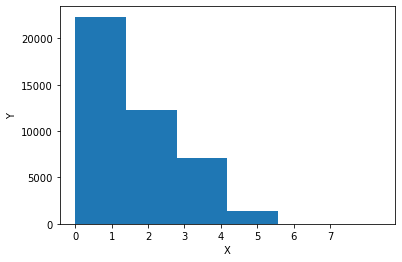

In [83]:
plt.figure()
plt.hist(np.log(arc_tract['num_surveys']),bins=6)
plt.xlabel("X")
plt.ylabel("Y")
plt.xticks(np.arange(8))
plt.show()

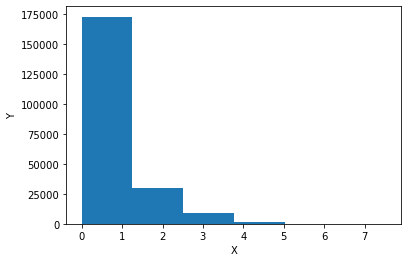

In [87]:
plt.figure()
plt.hist(np.log(arc_block['num_surveys']+1),bins=6)
plt.xlabel("X")
plt.ylabel("Y")
plt.xticks(np.arange(8))
plt.show()

In [61]:
np.arange(8)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [89]:
arc_block[arc_block['num_surveys'] > 30].shape[0]/ arc_block.shape[0]

Index(['010010201001', '010010201002', '010010202001', '010010202002',
       '010010203001', '010010203002', '010010204001', '010010204002',
       '010010204003', '010010204004',
       ...
       '560430003012', '560430003013', '560430003021', '560430003022',
       '560459511001', '560459511002', '560459513001', '560459513002',
       '560459513003', 'NA'],
      dtype='object', length=213715)

In [262]:
ACS.index.isin(arc_block.index).all()

True

In [263]:
blockGEOID = []
EstimateSurveyNumber = []
EstimateMean = []
EstimateCI   = []
EstimateGeography = []



for index, row in arc_block.iterrows():
    blockGEOID.append(index) 
    # append block GEOID-Data  
    if  len(row) != 0 and  row['num_surveys'] > 15:
        EstimateGeography.append('Block')
        EstimateSurveyNumber.append(row['num_surveys'])
        EstimateMean.append(row['detectors_working_prc'])
        EstimateCI.append(row['detectors_working_CI'])
        continue
    
    if index[:11] in arc_tract.index:
        curr_tract = arc_tract[arc_tract.index  ==  index[:11]].values[0]
        if len(curr_tract) != 0 and curr_tract[0] > 15:
            EstimateGeography.append('Tract')
            EstimateSurveyNumber.append(curr_tract[0])
            EstimateMean.append(curr_tract[-2])
            EstimateCI.append(curr_tract[-1])
            continue
    if index[:5] in arc_county.index:
        curr_county = arc_county[arc_county.index  ==  index[:5]].values[0]
        if len(curr_county) != 0 and  curr_county[0]  > 15:
            EstimateGeography.append('County')
            EstimateSurveyNumber.append(curr_county[0])
            EstimateMean.append(curr_county[-2])
            EstimateCI.append(curr_county[-1])
            continue
    else:
        curr_state = arc_state[arc_state.index  ==  index[:2]].values[0]
        EstimateGeography.append('State')
        EstimateSurveyNumber.append(curr_state[0])
        EstimateMean.append(curr_state[-2])
        EstimateCI.append(curr_state[-1])
    
    # zip and create geoid
    MultiLevelModel = pd.DataFrame( 
     [{'geoid': geoid,'estimate_geography': geo, 'num_surveys': ns , 'detectors_prc_mean': dpm , 'detectors_prc_ci': dci} for 
     geoid,geo,ns,dpm,dci in zip(blockGEOID,EstimateGeography,EstimateSurveyNumber,EstimateMean,EstimateCI) ]
    )
   


In [299]:
MultiLevelModel['geoid'] = '#_' + MultiLevelModel['geoid']

In [300]:
out_path =  path / 'Data' /'Model Outputs'/ 'SmokeAlarmModelOutput.csv'

MultiLevelModel.to_csv(out_path)

In [266]:
ACS.index.isin(MultiLevelModel['geoid'].str[2:]).all()

False

In [267]:
MultiLevelModelModel

,geoid,estimate_geography,num_surveys,detectors_prc_mean,detectors_prc_ci
0,010010201001,County,95.0,52.63,10.040669
1,010010201002,County,95.0,52.63,10.040669
2,010010202001,County,95.0,52.63,10.040669
3,010010202002,County,95.0,52.63,10.040669
4,010010203001,County,95.0,52.63,10.040669
...,...,...,...,...,...
195109,484971506033,County,31.0,51.61,17.592192
195110,484999501001,County,31.0,51.61,17.592192
195111,484999501002,County,31.0,51.61,17.592192
195112,484999501003,County,31.0,51.61,17.592192


In [296]:
MultiLevelModel

,geoid,estimate_geography,num_surveys,detectors_prc_mean,detectors_prc_ci
0,010010201001,County,95.0,52.63,10.040669
1,010010201002,County,95.0,52.63,10.040669
2,010010202001,County,95.0,52.63,10.040669
3,010010202002,County,95.0,52.63,10.040669
4,010010203001,County,95.0,52.63,10.040669
...,...,...,...,...,...
195109,484971506033,County,31.0,51.61,17.592192
195110,484999501001,County,31.0,51.61,17.592192
195111,484999501002,County,31.0,51.61,17.592192
195112,484999501003,County,31.0,51.61,17.592192


In [271]:
ACS.size

21949918

In [278]:
ACS[~ACS.index.isin(MultiLevelModel.index)]

,inc_pct_poverty,age_pct_under25,age_pct_25_64,age_pct_over65,educ_no_school,educ_nursery_4th,educ_5th_6th,educ_7th_8th,educ_9th,educ_10th,educ_11th,educ_12th_no_diploma,educ_high_school_grad,educ_col_less_1_yr,educ_some_col_no_grad,educ_associates,educ_bachelors,educ_masters,educ_professional,educ_docterate,worked_past_12_mo,did_not_work_past_12_mo,race_pct_white,race_pct_whitenh,race_pct_nonwhite,race_pct_nonwhitenh,race_pct_amind,race_pct_black,race_pct_hisp,house_pct_family,house_pct_family_married,house_pct_family_male_hh,house_pct_family_female_hh,house_pct_non_family,house_pct_live_alone,house_pct_no_live_alone,house_pct_occupied,house_pct_vacant,house_pct_ownd_occupied,house_pct_rent_occupied,house_pct_1_room,house_pct_2_room,house_pct_3_room,house_pct_4_room,house_pct_5_room,house_pct_6_room,house_pct_7_room,house_pct_8_room,house_pct_9_plus_room,house_yr_pct_2014_plus,house_yr_pct_2010_2013,house_yr_pct_2000_2009,house_yr_pct_1990_1999,house_yr_pct_1980_1989,house_yr_pct_1970_1979,house_yr_pct_1960_1969,house_yr_pct_1950_1959,house_yr_pct_1940_1949,house_yr_pct_earlier_1939,heat_pct_utility_gas,heat_pct_bottled_tank_lpgas,heat_pct_electricity,heat_pct_fueloil_kerosene,heat_pct_coal,heat_pct_wood,heat_pct_solar,heat_pct_other,heat_pct_no_fuel,house_pct_complete_plumb,house_pct_incomplete_plumb,house_pct_complete_kitchen,house_pct_incomplete_kitchen,house_w_1_mort,house_w_2_mort,house_w_home_equity_loan,house_w_both_2_mort_and_loan,house_no_mort,house_val_less_10K,house_val_10K_15K,house_val_15K_20K,house_val_20K_25K,house_val_25K_30K,house_val_30K_35K,house_val_35K_40K,house_val_40K_50K,house_val_50K_60K,house_val_60K_70K,house_val_70K_80K,house_val_80K_90K,house_val_90K_100K,house_val_100K_125K,house_val_125K_150K,house_val_150K_175K,house_val_175K_200K,house_val_200K_250K,house_val_250K_300K,house_val_300K_400K,house_val_400K_500K,house_val_500K_750K,house_val_750K_1M,house_val_1M_1.5M,house_val_1.5M_2M,house_val_more_2M
GEOID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
530019501001,0.076010,0.738717,0.494062,0.166271,0.010791,0.000000,0.000000,0.016187,0.026978,0.003597,0.012590,0.010791,0.294964,0.043165,0.131295,0.156475,0.196043,0.091727,0.005396,0.000000,0.628705,0.371295,0.956057,0.956057,0.043943,0.043943,0.029691,0.008314,0.005938,0.725490,0.689542,0.035948,0.000000,0.274510,0.254902,0.019608,0.959248,0.040752,0.774510,0.225490,0.000000,0.021944,0.000000,0.078370,0.109718,0.050157,0.194357,0.172414,0.373041,0.000000,0.072100,0.131661,0.018809,0.009404,0.040752,0.056426,0.068966,0.068966,0.532915,0.009804,0.000000,0.666667,0.261438,0.000000,0.016340,0.000000,0.045752,0.000000,1.000000,0.000000,0.949843,0.050157,0.350211,0.000000,0.000000,0.0,0.649789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.113924,0.000000,0.008439,0.042194,0.130802,0.000000,0.135021,0.109705,0.084388,0.177215,0.113924,0.000000,0.054852,0.000000,0.029536,0.000000,0.0
530019501002,0.101952,0.737219,0.572597,0.228016,0.005109,0.005109,0.000000,0.000000,0.003831,0.007663,0.006386,0.026820,0.307791,0.126437,0.143040,0.117497,0.141762,0.076628,0.019157,0.012771,0.603995,0.396005,0.906953,0.882413,0.093047,0.117587,0.002045,0.000000,0.061350,0.520343,0.428266,0.042827,0.049251,0.479657,0.430407,0.049251,0.817863,0.182137,0.695931,0.304069,0.029772,0.021016,0.068301,0.089317,0.129597,0.222417,0.087566,0.120841,0.231173,0.000000,0.000000,0.012259,0.043783,0.063047,0.173380,0.066550,0.169877,0.087566,0.383538,0.680942,0.000000,0.282655,0.023555,0.000000,0.006424,0.000000,0.000000,0.006424,0.968476,0.031524,0.935201,0.064799,0.393846,0.036923,0.024615,0.0,0.544615,0.000000,0.009231,0.009231,0.000000,0.012308,0.000000,0.027692,0.024615,0.018462,0.012308,0.009231,0.129231,0.064615,0.193846,0.123077,0.193846,0.083077,0.040000,0.027692,0.012308,0.000000,0.000000,0.009231,0.000000,0.000000,0.0
530019501003,0.192233,0.738832,0.541237,0.209622,0.016018,0.00000

In [288]:
x=ACS[~ACS.index.isin(MultiLevelModel['geoid'])]